<a href="https://colab.research.google.com/github/blazeAssault26/Vision-Based-Accident-Detection-System-for-Smart-City/blob/main/ads_resnet%2Bspinalnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, preprocessing, layers, applications, Model, optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, concatenate
import seaborn as sns
import cv2
import random
import os
from PIL import Image

In [3]:
batch_size = 100
img_height = 224
img_width = 224

In [4]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
     '/content/drive/MyDrive/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [7]:
batch_size = 100

train_datagen = ImageDataGenerator(
        rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    )

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
         '/content/drive/MyDrive/data/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator =validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='sparse')

Found 791 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [9]:
class SpinalNet(tf.keras.Model):
    def __init__(self, half_input, num_filters, num_classes):
        super(SpinalNet, self).__init__()

        self.half_input = half_input
        self.num_filters = num_filters
        self.num_classes = num_classes

        self.SpinalLayer1 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input,)),
            BatchNormalization(),
            ReLU(),
            # First layer use num_filters as input
        ])
        # Second till Output-1 layers use half_input+num_filters as input
        self.SpinalLayer2 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.SpinalLayer3 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.SpinalLayer4 = Sequential([
            Dropout(0.5),
            Dense(units=self.num_filters, input_shape=(self.half_input+self.num_filters,)),
            BatchNormalization(),
            ReLU(),
        ])

        self.Output = Sequential([
            Dropout(0.5),
            Dense(units=self.num_classes, input_shape=(self.num_filters*4,), activation ='softmax'),
            # num_filters times 4 ("4" here is number of SpinalNet I used)
        ])

    def call(self, x):
        x1 = self.SpinalLayer1(x[:, 0:self.half_input])
        x2 = self.SpinalLayer2(concatenate([x[:,self.half_input:2*self.half_input], x1], axis=1))
        x3 = self.SpinalLayer3(concatenate([ x[:,0:self.half_input], x2], axis=1))
        x4 = self.SpinalLayer4(concatenate([ x[:,self.half_input:2*self.half_input], x3], axis=1))

        x = concatenate([x1, x2])
        x = concatenate([x, x3])
        x = concatenate([x, x4])
        x = self.Output(x)

        return x

In [10]:
def ResNet50_Spinal(num_filters, num_classes):
    resnet = applications.ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    last_output = resnet.layers[-2].output
    num_features = resnet.layers[-1].input_shape[-1]
    half_input = round(num_features//2)
    num_filters = num_filters
    num_classes = num_classes
    spinalnet = SpinalNet(half_input = half_input, num_filters = 512, num_classes=num_classes)
    spinalnet.build(input_shape= (None, resnet.layers[-1].input_shape[-1]))
    input = Input(shape=last_output.shape[1:])
    x = spinalnet(last_output)
    resnet_model = keras.models.Model(inputs=resnet.input, outputs=x, name='ResNet101_SpinalNet')
    for layer in resnet.layers:
        layer.trainable = False
    return resnet_model

In [11]:
resnet_model = ResNet50_Spinal(num_filters = 20, num_classes = 2)

102967424/102967424 [==============================] - 1s 0us/step


In [12]:
resnet_model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    checkpoint = ModelCheckpoint('res_spinal.hdf5',verbose=1, save_best_only= True)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, checkpoint, early_stop]

In [14]:
history = resnet_model.fit(training_ds,
                           validation_data=validation_ds,
                           epochs=25,
                           batch_size=100,
                           callbacks=get_callbacks())


Epoch 1/25
8/8 [==============================] - ETA: 0s - loss: 0.8473 - accuracy: 0.6321 
Epoch 1: val_loss improved from inf to 0.82983, saving model to res_spinal.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 286s 28s/step - loss: 0.8473 - accuracy: 0.6321 - val_loss: 0.8298 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 2/25
8/8 [==============================] - ETA: 0s - loss: 0.7433 - accuracy: 0.6953 
Epoch 2: val_loss improved from 0.82983 to 0.51724, saving model to res_spinal.hdf5
8/8 [==============================] - 204s 26s/step - loss: 0.7433 - accuracy: 0.6953 - val_loss: 0.5172 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 3/25
8/8 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7446 
Epoch 3: val_loss improved from 0.51724 to 0.37587, saving model to res_spinal.hdf5
8/8 [==============================] - 207s 27s/step - loss: 0.5710 - accuracy: 0.7446 - val_loss: 0.3759 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 4/25
8/8 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.7560 
Epoch 4: val_loss did not improve from 0.37587
8/8 [==============================] - 186s 24s/step - loss: 0.5251 - accuracy: 

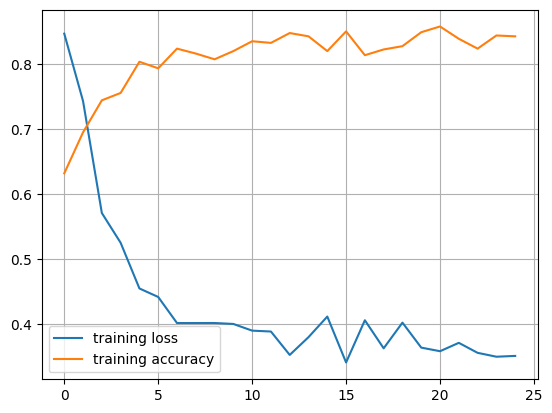

In [15]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

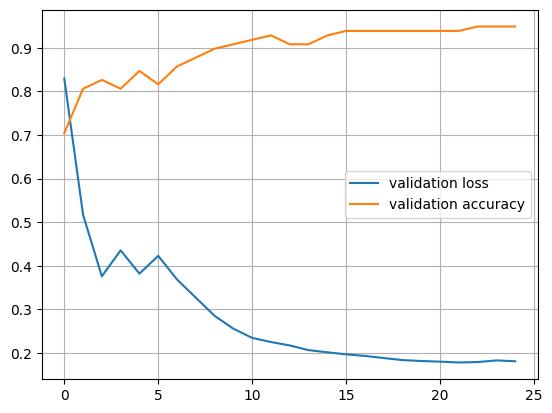

In [16]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 [==============================] - 29s 7s/step


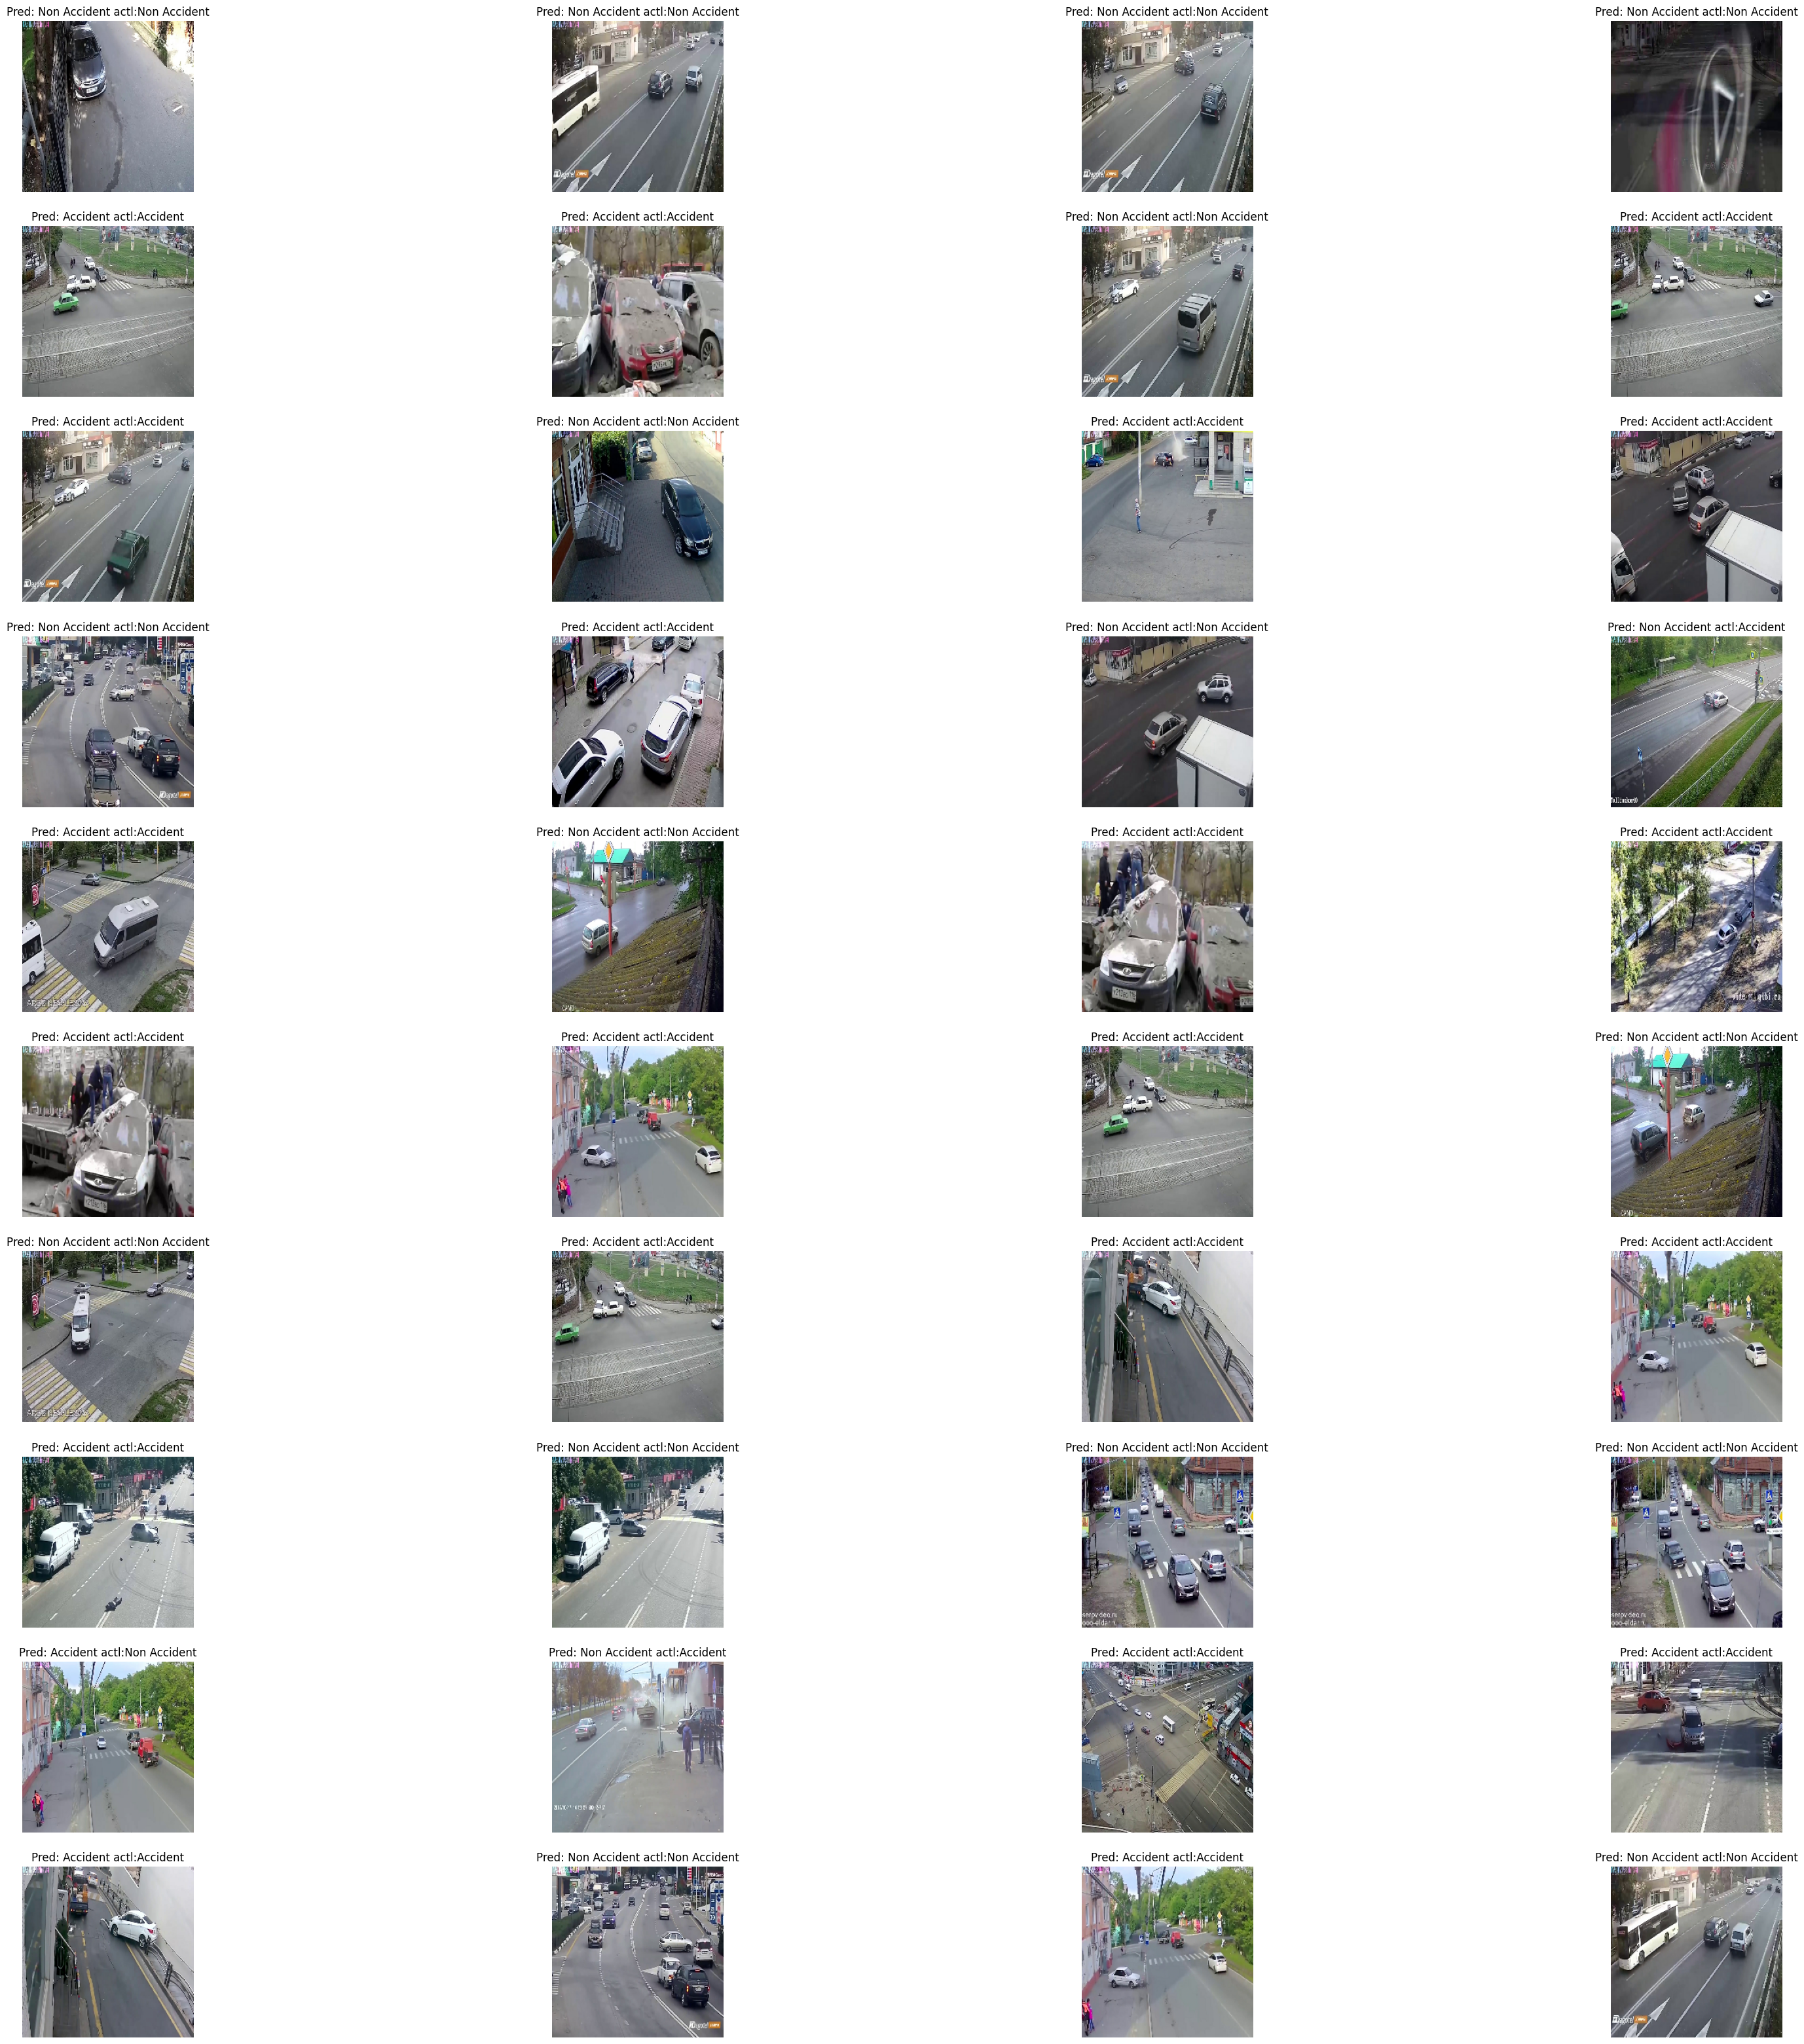

In [17]:
AccuracyVector = []
plt.figure(figsize=(40, 40))
for images, labels in testing_ds.take(1):
    predictions = resnet_model.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [18]:
truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0


for i in range(0,100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [19]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 43
True negatives are: 47
False negatives are: 4
False positives are: 6


In [27]:
from sklearn.metrics import classification_report

In [28]:
report = classification_report([1]*truePositive + [0]*falseNegative + [1]*falsePositive + [0]*trueNegative,
                               [1]*truePositive + [1]*falseNegative + [0]*falsePositive + [0]*trueNegative,
                               target_names=['Accident', 'Non Accident'])

print(report)

              precision    recall  f1-score   support

    Accident       0.89      0.92      0.90        51
Non Accident       0.91      0.88      0.90        49

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [29]:
resnet_model.save("ads_resnet+spinalnet.h5")
with tf.keras.utils.custom_object_scope({'SpinalNet': SpinalNet}):
    loaded_model = tf.keras.models.load_model("ads_resnet+spinalnet.h5")


loaded_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "ResNet101_SpinalNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                            